In [32]:
import pandas as pd
import numpy as np
import umap
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer

In [2]:
games=pd.read_csv('./games.csv')

In [3]:
## Encode binary vars to integers
games['rated_bin'] = np.where(games['rated'] == True, 1, 0)
games.drop(columns='rated',
          inplace=True)

In [19]:
games['winner_bin'] = np.where(games['winner'] == 'white', 0, 1)
games.drop(columns='winner',
          inplace=True)

In [4]:
## Opening, closing games data transformation
games['created_at_dt'] = pd.to_datetime(games['created_at']/1000, unit='s', origin='unix')
games['last_move_at_dt'] = pd.to_datetime(games['last_move_at']/1000, unit='s', origin='unix')

games['game_len_dt'] = games['last_move_at_dt'] - games['created_at_dt']
games['game_len'] = games['last_move_at'] - games['created_at']

games['game_len_mins'] = games['game_len_dt'].dt.components['minutes']

In [29]:
## Define nominal data variables to be thrown at one-hot-encoder
to_hot_encode = [
    'opening_eco',
    'increment_code',
    'victory_status'
]

In [33]:
## Define string variables for vectorization
to_vectorize = [
    'white_id',
    'black_id'
]

In [30]:
## Instantiate One Hot Encoder
ohe = OneHotEncoder(handle_unknown='error')

In [35]:
## Instantiate Count Vectorizer
cve = CountVectorizer()

In [41]:
## Set column transformer
column_trans = make_column_transformer(
    (ohe,to_hot_encode),
    remainder='passthrough')

In [42]:
## Fit column transformer
column_trans.fit(games[to_hot_encode])

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['opening_eco', 'increment_code',
                                  'victory_status'])])

In [47]:
## Produce one-hot-encoded array 
hot_encoded = column_trans.transform(games[to_hot_encode]).toarray()
hot_encoded_df = pd.DataFrame(hot_encoded, columns = column_trans.get_feature_names())

In [57]:
## Define cols to use
num_cols = [
    'winner_bin',
    'rated_bin',
    'game_len_mins',
    'turns',
#     'white_rating', #removed from the list as it dominates the structure
#     'black_rating', #removed from the list as it dominates the structure
    'opening_ply'
]

In [58]:
## Form final dataframe
hot_df = games[num_cols].merge(hot_encoded_df,
                     left_index=True,
                     right_index=True)

In [104]:
## Instantiate UMAP model
reducer = umap.UMAP(metric='euclidean')

In [105]:
## Train the model
embedding = reducer.fit_transform(hot_df)

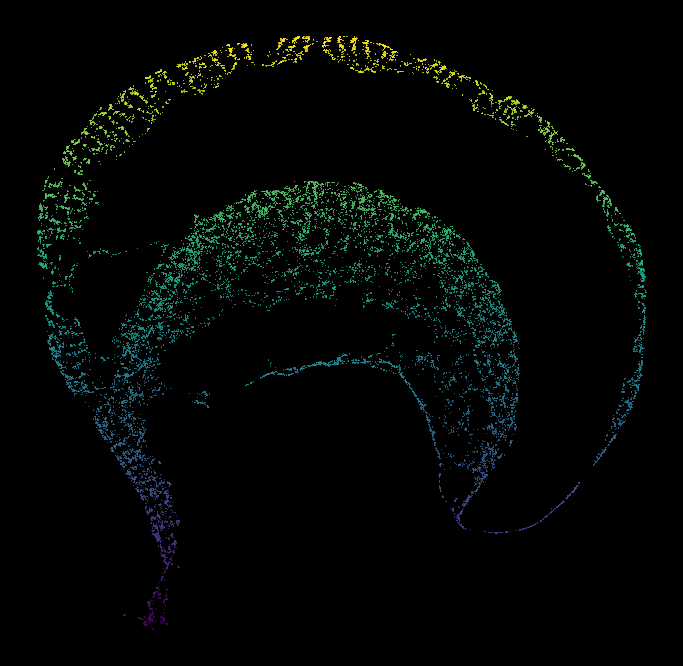

In [111]:
## Render vis
fig = plt.figure(figsize=(12,12))
fig.patch.set_facecolor('black')

plt.scatter(embedding[:,0], 
            embedding[:,1], 
            marker='s', 
            s=1.5, 
            edgecolor='none',
            c=embedding[:,1:], 
            cmap='viridis', alpha=0.8)

plt.axis("off")

plt.savefig("screens/euclidean_v02.png", dpi=600, facecolor='black')